# 確率ロボティクス2017第9回

上田隆一

2017年11月15日@千葉工業大学

## 今日やること

* 強化学習（古典的なもの）
* 参考: [Sutton and Barto, 三上, 皆川訳: 強化学習, 森北出版, 2000.](https://www.amazon.co.jp/dp/4627826613)
  * [ウェブ版 ](http://webdocs.cs.ualberta.ca/~sutton/book/ebook/the-book.html)
  * [そろそろ第2版が出るらしい](http://www.freetechbooks.com/reinforcement-learning-an-introduction-second-edition-draft-t1282.html)
  
## 強化学習（reinforcement learning）

* 機械学習の一種
  * 起源: 動物の心理学研究から[宮崎2005]
    * 餌にありつけるような/危険を避けるような行動の学習
  * 最近ANN（人工ニューラルネットワーク）との組み合わせで脚光を浴びている
  
## 基本的な強化学習の問題

* 有限MDPでの行動決定の問題に一つ制限を与える
  * 状態遷移と報酬が、行動しないと分からない。
* 問題の定義
  * 時刻: $\mathcal{T} = \{t | t = 0,1,2,\dots,T \}$
  * 状態: $\mathcal{S} = \{s_i | i = 1,2,3,\dots,N\}$
    * うち、いくつかは終端状態の集合$\mathcal{S}_\text{f}$に含まれる
  * 行動: $\mathcal{A} = \{a_j | j = 1,2,3,\dots,M\}$
  * 状態遷移$\mathcal{P}_{ss'}^a$や報酬$\mathcal{R}_{ss'}^a$は時不変だが自明でない
    * ある確率分布に従って状態遷移する
    * ある法則に従って報酬が与えられる 

## 何を求めたいのか

* 「最適方策」を求める
* 方策（二種類）
  * 決定論的方策: $\pi : \mathcal{S} \to \mathcal{A}$
    * 状態が決まると行動が決まるもの
  * 確率的な方策: $\pi : \mathcal{S}\times \mathcal{A} \to \Re$
    * 状態$s$において行動$a$を選択する確率
* 最適方策は決定論的になる（理由は次のページに）
  * $\pi^* : \mathcal{S} \to \mathcal{A}$
  
## 問題を解く道具

* ベルマン方程式が成り立つ
  * $V^*(s) = \max_{a \in \mathcal{A} } \sum_{s' \in \mathcal{S}}\mathcal{P}_{ss'}^a [V^*(s') +\mathcal{R}_{ss'}^a ]$
    * $V^*$: 最適状態価値関数
    * 左辺の「$\max_{a \in \mathcal{A} }$」を満たすものが最適方策$\pi^*$
* エージェントの「経験」
  * 状態遷移: ある状態$s$で行動$a$を選択したら状態$s'$に遷移して報酬を得た
  * たくさん行動すれば統計的な性質が得られる
  * たくさん行動しなければ統計的な性質が得られない
  
## 問題の難しさ

* 価値関数に停留点が一つでもあると、エージェントがその場に留まってしまう
* 膨大な試行が必要

## 方策を求めるには

* 何か適当な初期の方策を与えて価値関数がよくなるように方策を改善していけば良い
  * でもどうやって行動を選ぶのか？
* 様々な方法があるが本講義ではTD学習を説明

## TD（temporal difference）学習

* 行動した時に次の式で価値を更新
  * $V(s) \longleftarrow (1-\alpha)V(s) + \alpha[r + \gamma V(s')]$
    * $\alpha$: ステップサイズパラメータと呼ばれる
    * $\gamma$: 割引率
* 移動等の問題の場合は1で考えておいて良い
* 行動するたびに上の式で価値を更新
* 方策オン型（Sarsa）とオフ型（Q学習）
* 今日はワンステップのものしか扱わないが、一度の行動でいくつかの状態を変更する効率の良い方法も（TD$(\lambda$)）

## Sarsa

* 方策ON型TD学習
* 行動価値を学習
  * $Q(s,a) ← (1-\alpha )Q(s,a) + \alpha[r + \gamma Q(s',a')]$
* 手順
  1.$Q(s,a)$を初期化
  1.$\epsilon$-グリーディ方策等から行動$a$を選択
  1.行動$a$をとり、$s'$に移った後、次の行動$a'$を選択
  1.上の式で$Q(s,a)$を更新
  
## Q学習

* 方策オフ型TD学習
* 次の式を使う
  * $Q(s,a) ← (1-\alpha )Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a')]$
* $\epsilon$-グリーディ方策を使っても非グリーディな行動が価値関数に影響を与えない

## 実装してみましょう

### エージェントの定義

価値反復と違ってエージェントを実際に動かしながら学習するので必要となる。

In [10]:
class Agent:
    def __init__(self):
        self.actions = ["up","down","left","right"]
        self.cur_state = (0,0)
        
agent = Agent()

### 環境の定義

先週よりややこしいので状態をクラスにします。雑なので各自リファクタリングのこと。

In [11]:
class State:
    def __init__(self,isgoal,actions):
        self.Q = [100.0 for e in actions]
        self.value = 100.0
        self.best_action = actions[0]
        self.goal = isgoal

size = 3
states = [[State(False,agent.actions) for i in range(size)] for j in range(size)]
states[2][2].goal = True
states[2][2].value = 0.0

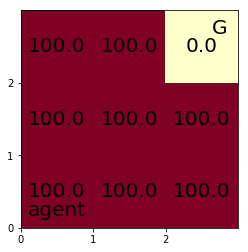

In [18]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[i][j].value for j in range(size)] for i in range(size)]
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd,vmin=0,vmax=8)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            plt.text(x+0.5,y+0.5,int(1000*states[x][y].value)/1000,ha = 'center', va = 'center', size=20)
            if states[x][y].goal:
                plt.text(x+0.75,y+0.75,"G",ha = 'center', va = 'center', size=20)
                
    plt.text(agent.cur_state[0]+0.5,agent.cur_state[0]+0.25,"agent",ha = 'center', va = 'center', size=20)
    
    if mark_pos == "all":   # 指定した位置にactionの文字列を書くという処理
        for x in range(size):
            for y in range(size):
                plt.text(x+0.5,y+0.25,states[x][y].best_action,ha = 'center', va = 'center', size=20)
    elif mark_pos != None: 
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5,mark_pos[1]+0.25,s.best_action,ha = 'center', va = 'center', size=20)
            
    plt.show()
    fig.clear()
    
draw(None)

In [ ]:
def one_step():
    pass